## Imports

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import tensorflow as tf
import re

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
K.clear_session()

## Functions

In [17]:
# extract prefix to group by participant insted of trip
def extract_prefix(filename):
    # split filename on '_' 
    return re.split(r'_', filename)[0]

# create sequences of consecutive intrevales 
def create_sequences(data, labels, filenames, window_size):
    # vars to store the sequences and the respective labels
    sequences = []
    sequence_labels = []
    
    # get the file name to filter by participant
    current_prefix = extract_prefix(filenames[0])
    current_sequence = []
    current_labels = []
    
    # loop all intrevals
    for i in range(len(data)):
        # get current filename
        prefix = extract_prefix(filenames[i])
        
        # if the intreval belongs to diferent participant reset the sequences and vars
        if prefix != current_prefix:
            current_prefix = prefix
            current_sequence = [] 
            current_labels = []

        # add the intrevlal and the label to the current sequence
        current_sequence.append(data[i])
        current_labels.append(labels[i])
        
        # check if the sequence reach the max size and if so, store the sequence and the lable
        if len(current_sequence) == window_size:
            sequences.append(current_sequence.copy()) 
            sequence_labels.append(current_labels[-1]) 
            current_sequence.pop(0)

    return np.array(sequences), np.array(sequence_labels)

## Data Pre-Processing

In [9]:
# get data
file_path_1 = '../pre_process_2/datasets_v2/supervised_1_min.csv'
df_1_min = pd.read_csv(file_path_1, delimiter=',')

# filenames with the "pvt recording"
filenames_to_remove = [
    "fp01_2.csv", "fp01_4.csv", "fp02_1.csv", "fp02_2.csv", "fp02_4.csv",
    "fp03_1.csv", "fp03_2.csv", "fp04_1.csv", "fp05_1.csv", "fp06_1.csv",
    "fp07_1.csv", "fp08_1.csv", "fp09_1.csv", "fp10_1.csv", "fp11_1.csv",
    "fp12_1.csv", "fp13_1.csv", "fp14_1.csv", "fp14_3.csv", "fp15_1.csv",
    "fp16_1.csv", "fp17_1.csv", "fp17_2.csv", "fp17_4.csv", "fp18_1.csv",
    "fp18_2.csv", "fp19_1.csv", "fp19_3.csv", "fp19_4.csv", "fp20_1.csv", 
    "fp20_3.csv"
]

#remove the unwanted instances from the dfs
df_1_min = df_1_min[~df_1_min['Filename'].isin(filenames_to_remove)]

# remove columns with null values
df_1_min = df_1_min[(df_1_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]

# remove missing values
df_1_min = df_1_min.dropna()

# get wanted features for training data
df_features_1_min = df_1_min[(df_1_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]

# final wanted features
features_1_min = df_features_1_min.columns.to_list()

In [18]:
df_1_min['Filename']

0       fp01_1.csv
1       fp01_1.csv
2       fp01_1.csv
3       fp01_1.csv
4       fp01_1.csv
           ...    
4353    fp20_4.csv
4354    fp20_4.csv
4355    fp20_4.csv
4356    fp20_4.csv
4357    fp20_4.csv
Name: Filename, Length: 2721, dtype: object

In [11]:
df_1_min.shape

(2721, 31)

### Normalization

In [ ]:
# normalize data
scaler = StandardScaler()
X_scaled_1_min = scaler.fit_transform(df_1_min[features_1_min].values)

### Descretrization

In [13]:
# descretize the value of KSS
labels_1_min = (df_1_min['kss_answer'] > 6).astype(int)

### Prepare data to train the model

In [ ]:
# get all filenames
filenames_1_min = df_1_min['Filename'].values

# number of intrevlas in sequence
window_size = 6 

# create sequences and respective lables
X_sequences_1_min, y_sequences_1_min = create_sequences(X_scaled_1_min, labels_1_min.values, filenames_1_min, window_size)

# Verify shape of sequences
print("Shape of X_sequences of 1 Min :", X_sequences_1_min.shape)
print("Shape of y_sequences of 1 Min:", X_sequences_1_min.shape)

# test and train data split
X_train_1_min, X_test_1_min, y_train_1_min, y_test_1_min = train_test_split(X_sequences_1_min, y_sequences_1_min, test_size=0.20, random_state=42)

Shape of X_sequences of 1 Min : (2701, 2, 27)
Shape of y_sequences of 1 Min: (2701, 2, 27)


### Create LSTM Model

In [ ]:
# define LSTM Model for 1 min
model_1_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(X_train_1_min.shape[1], X_train_1_min.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model_1_min.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\duart\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train Model

In [27]:
# train
history_1_min = model_1_min.fit(X_train_1_min, y_train_1_min, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4953 - loss: 0.6942 - val_accuracy: 0.6620 - val_loss: 0.6511
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.6422 - loss: 0.6431 - val_accuracy: 0.6991 - val_loss: 0.6166
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.6874 - loss: 0.6119 - val_accuracy: 0.7060 - val_loss: 0.5851
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.6995 - loss: 0.5902 - val_accuracy: 0.7269 - val_loss: 0.5625
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7160 - loss: 0.5687 - val_accuracy: 0.7407 - val_loss: 0.5495
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.7232 - loss: 0.5564 - val_accuracy: 0.7384 - val_loss: 0.5429
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.7302 - loss: 0.5519 - val_accuracy: 0.7315 - val_loss: 0.5357
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.7273 - loss: 0.5423 - val_accura

### Evaluation and Visualization

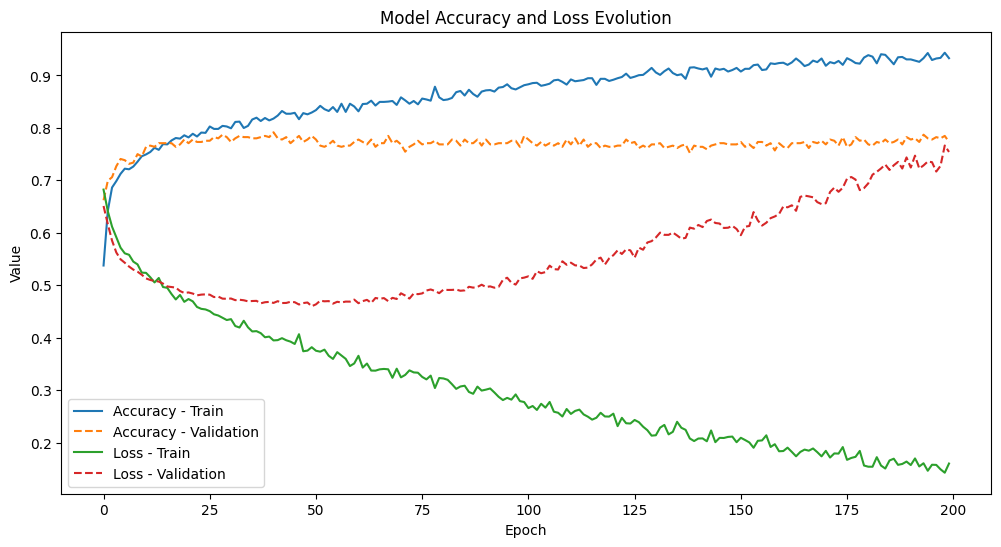

In [28]:
# plot for accuracy and loss
plt.figure(figsize=(12, 6))

# accuracy
plt.plot(history_1_min.history['accuracy'], label='Accuracy - Train')
plt.plot(history_1_min.history['val_accuracy'], label='Accuracy - Validation', linestyle='--')

# loss
plt.plot(history_1_min.history['loss'], label='Loss - Train')
plt.plot(history_1_min.history['val_loss'], label='Loss - Validation', linestyle='--')

# titles and labels
plt.title('Model Accuracy and Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='best')

# Show the plot
plt.show()

## Models Predictions

### ROC Curve

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Final Test Predictions Results for Model 1 min: 
  Accuracy: 0.763
  Precision: 0.766
  Recall: 0.823
  F1 Score: 0.794


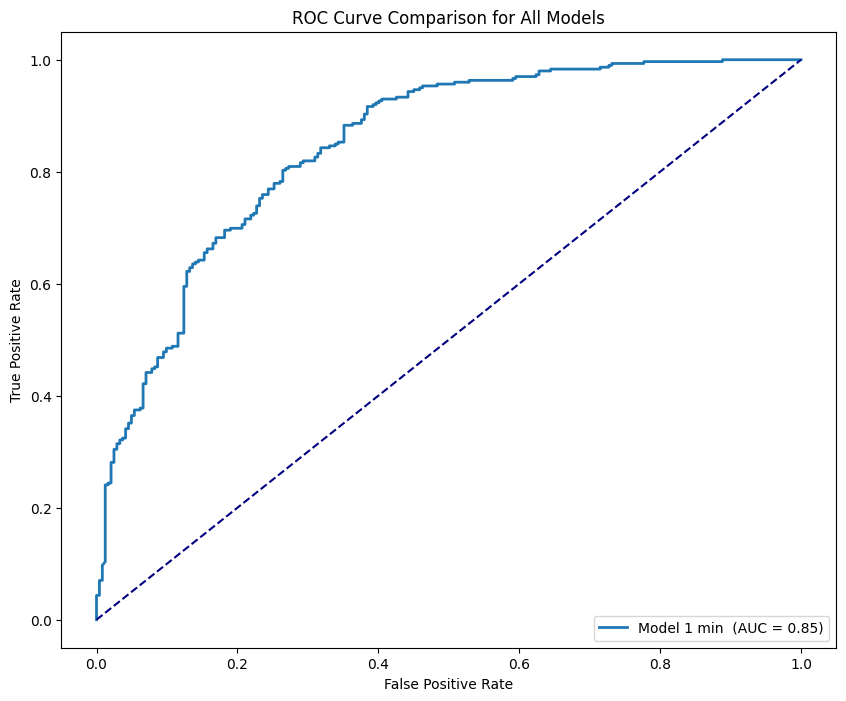

In [29]:
# module name
name = 'Model 1 min'

# ROC plot setup
plt.figure(figsize=(10, 8))

# make predictions
y_pred = model_1_min.predict(X_test_1_min)
y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)  # threshold and reshape to binary

# evaluation metrics
accuracy = accuracy_score(y_test_1_min, y_pred_binary)
precision = precision_score(y_test_1_min, y_pred_binary)
recall = recall_score(y_test_1_min, y_pred_binary)
f1 = f1_score(y_test_1_min, y_pred_binary)
    
# print results for the model
print(f"Final Test Predictions Results for Model 1 min: ")
print(f'  Accuracy: {accuracy:.3f}')
print(f'  Precision: {precision:.3f}')
print(f'  Recall: {recall:.3f}')
print(f'  F1 Score: {f1:.3f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_1_min, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Model 1 min  (AUC = {roc_auc:.2f})')

# plot all ROC curves together
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for All Models')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


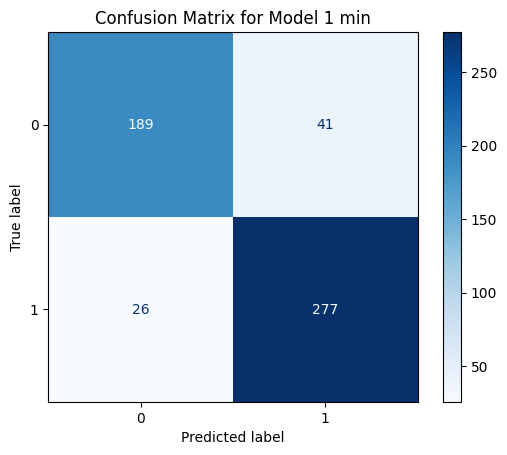

In [24]:
# CM
y_pred_binary = (model_1_min.predict(X_test_1_min) > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(y_test_1_min, y_pred_binary)

# plot CM
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Model 1 min')
plt.show()